# INM433 Coursework data
## Tasks
1. Generate correlation coefficients for all log files  

In [2]:
%matplotlib inline

###########################
## PROCESS ALL LOG FILES ##
###########################

# helper functions
def getBiasVoltages(iBv):
    # Expecting a byte value e.g. 99 cast as int (153)
    FlMask = 0xF0 # mask for the flame voltage bias i.e. 11110000
    FRshift = 4 # number of right shifts e.g. start with 0x99, end with 0x09
    GMask = 0x0F # mask for the guard voltage bias, no need to shift
    iFbv = (iBv & FlMask) >> FRshift 
    iGbv = iBv & GMask 
    return iFbv, iGbv

def getAlarmGainSpikeCount(iEvent):
    # Byte 6:  EVENT (MSB-LSB: Alarm\Gain\0\Spike\Count\Count\Count\Count) -check
    # Alarm = bit 7
    # Gain = bit 6
    # Spike = bit 4
    # Count = bits 0,1,2,3
    # Notes; count is a sequential 4 bit count, expected to be continuous and
    # carry over o 15, restarting at 0. If any values are found to be missing, action
    # might be required, e.g. linear interpolation to patch missing observations
    AMask = 0x80 # 10000000
    ARshift = 7
    GMask = 0x40 # 01000000
    GRshift = 6
    SMask = 0x10 # 00010000
    SRshift = 4
    CMask = 0x0F # 00001111
    # no shift required for count
    Alarm = (iEvent & AMask) >> ARshift
    Gain = (iEvent & GMask) >> GRshift
    Spike = (iEvent & SMask) >> SRshift
    Count = (iEvent & CMask)
    return Alarm, Gain, Spike, Count

def processLog(filePath, filename):
    # expected return values are
    # FlameA, FlameB, Guard, Flame A&B bias voltage, Alarm (true/false), Gain(true/false)
    # Spike(true/false) and Count(4 bit running count)
    import numpy as np
    # vars
    # expected record length
    iRecLen = 12
    # initialise empty return array
    retarr = np.empty((0,9), dtype='uint8')

    logfilename = filePath + filename
    file = open(logfilename, "r")
    for line in file:
        line = line.rstrip()
        if((len(line) == iRecLen) & (line.find(" ") < 0)):
            # FlameA, FlameB and Guard detector analogue readings
            iFAv = int(line[0:2], 16)
            iFBv = int(line[2:4], 16)
            iG = int(line[4:6], 16)
            iBv = int(line[6:8], 16)
            iFbv, iGbv = getBiasVoltages(iBv)
            iEvent = int(line[10:12], 16)
            Alarm, Gain, Spike, Count = getAlarmGainSpikeCount(iEvent)
            retarr = np.append(retarr, [[iFAv, iFBv, iG, iFbv, iGbv, Alarm, Gain, Spike, Count]],axis = 0)
    return retarr

def getLogfiles(path, pattern):
    # return a list of files
    import glob
    files = []
    for name in glob.glob(path + pattern):
        files.append(name[len(path):])
    return files

def gainPolygon(farr, plt):
    Sidx = 6 # gain flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    # show gain on the lower part of the plot
    maxY = int(maxY/8)
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Sidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            # greenish colour
            plt.fill(xPol, yPol, '#02fe02')

def spikePolygon(farr, plt):
    Sidx = 7 # spike flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Sidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            plt.fill(xPol, yPol, '#0200fe')
            
def alarmPolygon(farr, plt):
    Aidx = 5 # alarm flag index
    iSize = farr[0:,0].size 
    # y axys polygon edges
    #maxY = np.max(farr[:,0])
    #minY = np.min(farr[:,0])
    maxY = np.max([np.max(farr[:,0]), np.max(farr[:,1])])
    minY = np.min([np.min(farr[:,0]), np.min(farr[:,1])])    
    yPol = [minY,maxY,maxY,minY]
    for i in range(iSize):
        # check if Alarm polygon needs to be plotted
        if ((farr[i,Aidx] == 1) & ((i+1) <= iSize)):
            xPol = [i, i, i+1, i+1]
            plt.fill(xPol, yPol, '#fe0002')

def plotFlamedata(farr, file):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    # indices
    FAidx = 0
    FBidx = 1
    Gidx = 2
    # x axis time series array
    iIdx = np.arange(1, farr[:,0].size + 1, 1) # iIdx = np.arange(1, iGlfd.size + 1, 1)
    plt.clf()
    figWidthScale = 66 # 1150 points for every 18 inches
    figHeight = 10
    figWidth = farr[:,FAidx].size / figWidthScale # about 484 inches for a 30 second capture
    plt.figure(figsize=(figWidth,figHeight))
    plt.plot(iIdx, farr[:,FAidx], label='FlameA')
    plt.plot(iIdx, farr[:,FBidx], label='FlameB')
    plt.plot(iIdx, farr[:,Gidx], label='Guard')
    # fill spike state indicator bar
    spikePolygon(farr, plt)
    # Fill Alarm state indicator bar
    alarmPolygon(farr, plt) 
    # Fill Gain state indicator bar
    # Gain data is not telling us much so we'll leave it out
    # gainPolygon(farr, plt)     
    plt.xlabel('Time(ms)')
    plt.ylabel('AD values')
    plt.title("Flame data - " + file)
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1)
    # scale y 0 to 255
    plt.ylim(0, 255)
    plt.show()

def plotLinearRegression(farr, file):
    from scipy.stats import linregress 
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    
    FAidx = 0
    FBidx = 1    
    x = farr[:,FAidx]
    y = farr[:,FBidx]
    # plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)

    b, m = np.polyfit(x, y, 1)

    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.scatter(x,y, c = 'Red', s = 50, linewidth = 0)
    plt.title(file + " - " + str(np.around(rvalue, decimals=4)))
    plt.xlabel("Channel 1 Normalised")
    plt.ylabel("Channel 2 Normalised")
    plt.show()

In [3]:
# process all log files
import numpy as np
path = "../../INM430/coursework/data/full-set/"
pattern = "*.log"
# pattern = "Test45.log"
logs = getLogfiles(path, pattern)
for log in logs:
    #arr = processLog(path, log)
    #plotFlamedata(arr, log)
    print(log)

Test45.log
Test46.log
Test47.log
Test48.log
Test49.log
Test50.log
Test51.log
Test52.log
Test53.log
Test54.log
Test55.log
Test56.log
Test57.log
Test58.log
Test59.log
Test60.log
Test61.log
Test62.log
Test63.log
Test64.log
Test65.log
Test66.log
Test67.log
Test68.log
Test69.log
Test70.log
Test71.log
Test72.log


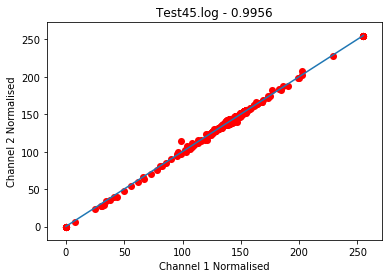

In [8]:
# process one log file
import numpy as np
path = "../../INM430/coursework/data/full-set/"
pattern = "Test45.log"
# pattern = "Test45.log"
logs = getLogfiles(path, pattern)
for log in logs:
    arr = processLog(path, log)
    plotLinearRegression(arr, log)
    # print(log)

In [15]:
# create 6 subplots
# process all log file
logarrays = []
import numpy as np
path = "../../INM430/coursework/data/full-set/"
pattern = "*.log"
# pattern = "Test45.log"
logs = getLogfiles(path, pattern)
for log in logs:
    arr = processLog(path, log)
    # plotLinearRegression(arr, log)
    logarray = {
        'logfile' : log,
        'arraydata' : arr
    }
    logarrays.append(logarray)

#plotLinearRegression(arr, log)

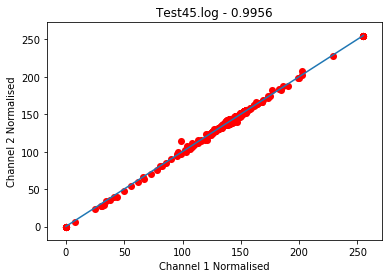

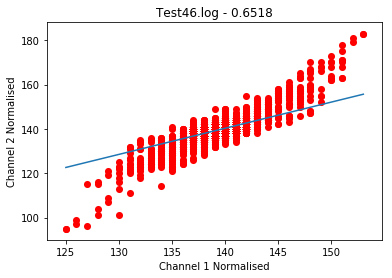

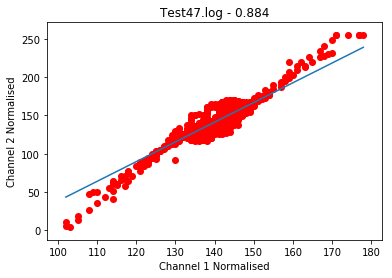

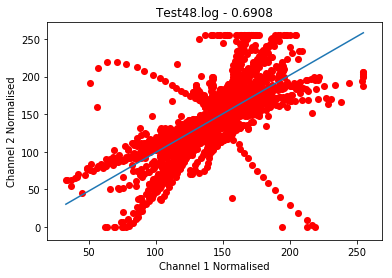

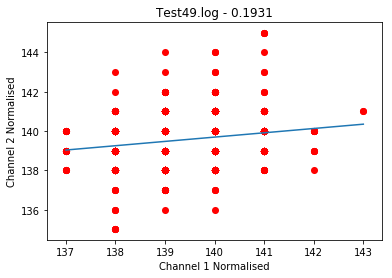

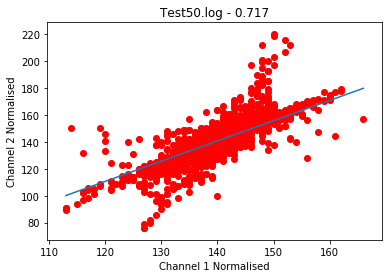

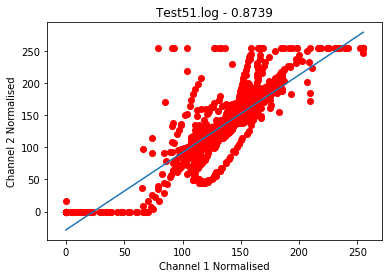

In [19]:
for i in range (0,7):
    plotLinearRegression(logarrays[i]['arraydata'], logarrays[i]['logfile'])



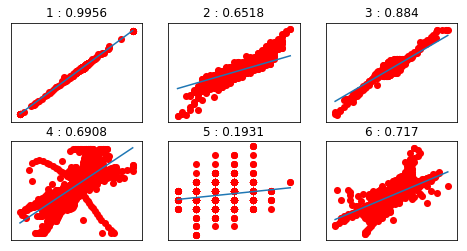

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from scipy.stats import linregress 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
    
plt.figure(figsize=(8,4))       # set dimensions of the figure
for i in range(0,6):
    plt.subplot(2,3, i + 1)         # create subplots on a grid with 2 rows and 3 columns
    plt.xticks([])              # set no ticks on x-axis
    plt.yticks([])              # set no ticks on y-axis

    FAidx = 0
    FBidx = 1    
    x = logarrays[i]['arraydata'][:,FAidx]
    y = logarrays[i]['arraydata'][:,FBidx]

    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)

    b, m = np.polyfit(x, y, 1)

    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.scatter(x,y, c = 'Red', s = 50, linewidth = 0)
    #plt.title(file + " - " + str(np.around(rvalue, decimals=4)))
    #plt.xlabel("Channel 1 Normalised")
    #plt.ylabel("Channel 2 Normalised")    
    
    #plt.plot(np.sin(x), np.cos(i*x))
    plt.title(str(i + 1) + " : " + str(np.around(rvalue, decimals=4)))

plt.show()



# Data object
We need an object that will hold data and metadata
**Data**
* Channel 1 original data
* Channel 2 original data

**Engineered features** 
* Antiphase Array (boolean)
* Channel 1 normalised data
* Channel 2 normalised data
* Normalised distance array
* Normalised antiphase array
* Antiphase array
* SG filter Channel 1 normalised
* SG filter Channel 2 normalised
* SG filter distance array 
* SG filter antiphase array 
* LI filter Channel 1 normalised
* LI filter Channel 2 normalised
* LI filter distance array
* LI filter antiphase array

**Metadata**
* File name
* Correlation Coefficient
* Savistzky Golay correlation Coefficient
* Linear interpolation correlation coefficient
* Normalised distance
* Normalised antiphase
* SG normalised distance
* SG normalised antiphase
* LI normalised distance
* LI normalised antiphase

In [49]:
# Our new array object
# iFNa - normalised channel 1
# iFNb - normalised channel 2
# iA - antiphase
# iD - distance function

# Antiphase function
def antiphase(fa, fap, fb, fbp):
    if(fb-fbp == 0):
        return False
    else:
        return (fa-fap)/(fb - fbp) < 0

# Antiphase array
def antiphaseArray(arr1, arr2):
    # dinitialise return array to zeroes
    retarr = np.zeros(arr1.size)
    for i in range(1,retarr.size):
        retarr[i] = antiphase(arr1[i], arr1[i - 1], arr2[i], arr2[i - 1])
    return retarr

# add a normalised column, our first engineered feature
def norm(x, iMin, iMax):
    # need to add a safety net here, in case max and min are the same
    if((iMax - iMin) == 0):
        return 0;
    return (x - iMin) / (iMax - iMin)


In [60]:
# to simplify things and start dealing with human-readable labels, instead of numbers
# create an array of dictionaries to hold all our data
logarrays = []
import numpy as np
path = "../../INM430/coursework/data/full-set/"
pattern = "Test45.log"
# pattern = "Test45.log"
logs = getLogfiles(path, pattern)
for log in logs:
    arr = processLog(path, log)
    channelA = arr[:,0]
    channelB = arr[:,1]
    # plotLinearRegression(arr, log)
    logarray = {
        'logfile' : log,
        'channel-1-raw-data' : channelA,
        'channel-2-raw-data' : channelB,
        'channel-1-normalised' : norm(channelA, 0, 255),
        'channel-2-normalised' : norm(channelB, 0, 255),        
        'original-raw-distance' : np.abs(channelA - channelB),
        'original-raw-antiphase' : antiphaseArray(channelA ,channelB)
    }
    logarrays.append(logarray)

In [63]:
logarrays[0]['correlation-coefficient'] = 0.9957

Text(0.5,1,'6 : 0.9956')

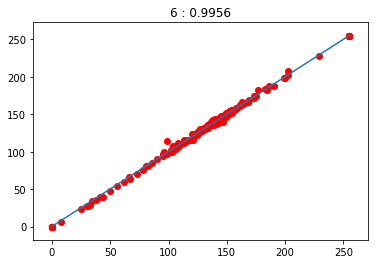

In [38]:
    FAidx = 0
    FBidx = 1    
    x = logarrays[0]['channel-1-original']
    y = logarrays[0]['channel-2-original']

    slope, intercept, rvalue, pvalue, stderr = linregress(x, y)

    b, m = np.polyfit(x, y, 1)

    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.scatter(x,y, c = 'Red', s = 50, linewidth = 0)
    #plt.title(file + " - " + str(np.around(rvalue, decimals=4)))
    #plt.xlabel("Channel 1 Normalised")
    #plt.ylabel("Channel 2 Normalised")    
    
    #plt.plot(np.sin(x), np.cos(i*x))
    plt.title(str(i + 1) + " : " + str(np.around(rvalue, decimals=4)))

In [64]:
logarrays[0]['correlation-coefficient']

0.9957